In [10]:
import pandas as pd

import torch.nn as nn
import torch

import copy
import re
import networkx as nx
import matplotlib.pyplot as plt

import plotly.graph_objects as go
import os
import numpy as np

import seaborn as sns

In [11]:
class PimaClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden1 = nn.Linear(8, 32)
        self.act1 = nn.ReLU()
        self.hidden2 = nn.Linear(32, 64)
        self.act2 = nn.ReLU()
        self.hidden3 = nn.Linear(64, 16)
        self.act3 = nn.ReLU()
        self.output = nn.Linear(16, 1)
        self.act_output = nn.Sigmoid()

    def forward(self, x):
        x = self.act1(self.hidden1(x))
        x = self.act2(self.hidden2(x))
        x = self.act3(self.hidden3(x))
        x = self.act_output(self.output(x))
        return x
    
    
def load_model():
    model = torch.load('model_training/model')
    model.eval()
    return model

def eval_model(model, input):
    # print(input)
    with torch.no_grad():
        prob = model(input)
    return prob.tolist()[0]


def load_data(data):
    return np.load(data)

def apply_phenotype(array, phenotype):
    # Split the phenotype string into individual operations
    operations = phenotype.split(';')
    x = copy.deepcopy(array)
    # Iterate over each operation and execute it
    for operation in operations:
        # Strip any leading/trailing whitespace from the operation
        operation = operation.strip()
        
        # Use the exec function to execute the operation on the array
        if operation:
            exec(operation)

    return x

def combine_operations(phenotype, original_input):
    combined_operations = []
    processed_input = apply_phenotype(original_input, phenotype)
    change =  processed_input - original_input
    
    # print(change)
    for i, j  in enumerate(change):
        if j == 0:
            continue
        else:
            if j > 0:
                combined_operations.append(f'x[{i}] += {j}')
            else:
                combined_operations.append(f'x[{i}] -= {-j}')
                
    return '; '.join(combined_operations)

def count_index_cooccurrences(phenotypes, num_indices):
    # Initialize the correlation matrix
    correlation_matrix = np.zeros((num_indices, num_indices), dtype=int)
    
    # Iterate over each phenotype
    for phenotype in phenotypes:
        # Split the phenotype string into individual operations
        operations = phenotype.split(';')
        
        for index, operation in enumerate(operations):
            # print(index)
            if index == len(operations) - 1:
                continue
            else:
                operation = operation.strip()
                # print(operation)
                
                if not operation:
                    continue
                
                # Parse the operation to extract the index
                current_feature = int(operation.split()[0][2:-1])
                next_feature = int(operations[index + 1].split()[0][2:-1])# Extract the index
                
                # print(current_feature, next_feature)
                
                if current_feature == next_feature:
                    continue
                else:
                    correlation_matrix[current_feature, next_feature] += 1
                    correlation_matrix[next_feature, current_feature] += 1
    

    normalized_matrix = correlation_matrix/np.linalg.norm(correlation_matrix) 
    
    return normalized_matrix, correlation_matrix

# def count_index_cooccurrences(phenotypes, num_indices):
#     # Initialize the correlation matrix
#     correlation_matrix = np.zeros((num_indices, num_indices), dtype=int)
# 
#     # Iterate over each phenotype
#     for phenotype in phenotypes:
#         # Split the phenotype string into individual operations
#         operations = phenotype.split(';')
# 
#         # Track the indices that appear in the current phenotype
#         indices_set = set()
# 
#         for operation in operations:
#             # Strip any leading/trailing whitespace from the operation
#             operation = operation.strip()
# 
#             if not operation:
#                 continue
# 
#             # Parse the operation to extract the index
#             index = int(operation.split()[0][2:-1])  # Extract the index
#             indices_set.add(index)
# 
#         # Convert set to list for iteration
#         indices_list = list(indices_set)
# 
#         # Update the correlation matrix based on the current phenotype
#         for i in range(len(indices_list)):
#             for j in range(i + 1, len(indices_list)):
#                 # Off-diagonal elements, count co-occurrences
#                 correlation_matrix[indices_list[i], indices_list[j]] += 1
#                 correlation_matrix[indices_list[j], indices_list[i]] += 1
# 
#     # Set the diagonal elements to the number of phenotypes
#     # np.fill_diagonal(correlation_matrix, len(phenotypes))
#     # 
#     # # Normalize the correlation matrix by dividing by the number of phenotypes
#     # normalized_matrix = correlation_matrix / len(phenotypes)
#     normalized_matrix = correlation_matrix/np.linalg.norm(correlation_matrix) 
# 
#     return normalized_matrix, correlation_matrix

def create_graph_from_matrix(matrix):
    # Create an undirected graph
    G = nx.Graph()
    
    # Get the number of nodes
    num_nodes = matrix.shape[0]
    
    # Add nodes to the graph
    for i in range(num_nodes):
        G.add_node(i)
    
    # Add edges to the graph based on the normalized co-occurrence matrix
    for i in range(num_nodes):
        for j in range(i + 1, num_nodes):
            if matrix[i, j] > 0:
                G.add_edge(i, j, weight=matrix[i, j])
    
    return G


def draw_graph_plotly(G, features):
    # Extract node positions
    pos = nx.spring_layout(G, seed=10)
    
    # Create edges
    edge_x = []
    edge_y = []
    edge_weights = []
    mnode_x, mnode_y, mnode_txt = [], [], []
    for edge in G.edges(data=True):
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_x.extend([x0, x1, None])
        edge_y.extend([y0, y1, None])
        edge_weights.append(edge[2]['weight'])
        mnode_x.extend([(x0 + x1)/2]) # assuming values positive/get midpoint
        mnode_y.extend([(y0 + y1)/2]) # assumes positive vals/get midpoint
        mnode_txt.extend([f"Edge ({edge[0]} - {edge[1]}): {edge[2]['weight']}"])
    
    # Create edge trace
    edge_trace = go.Scatter(
        x=edge_x, y=edge_y,
        line=dict(width=0.5, color='#888'),
        hoverinfo='text',
        mode='lines')
    
    # Create edge text for hovering
    mnode_trace = go.Scatter(x = mnode_x, y = mnode_y, mode = "markers", showlegend = False,
                         hovertemplate = " %{hovertext}<extra></extra>",
                         hovertext = mnode_txt, marker = go.scatter.Marker(opacity = 0))

    
    # Create node trace
    node_x = []
    node_y = []
    for node in G.nodes():
        x, y = pos[node]
        node_x.append(x)
        node_y.append(y)
    
    node_trace = go.Scatter(
        x=node_x, y=node_y,
        mode='markers',
        hoverinfo='text',
        marker=dict(
            showscale=True,
            colorscale='YlGnBu',
            reversescale=True,
            color=[],
            size=10,
            colorbar=dict(
                thickness=15,
                title='Node Connections',
                xanchor='left',
                titleside='right'
            ),
            line_width=2))
    
    # Add node connectivity as node attribute
    node_adjacencies = []
    node_text = []
    for node, adjacencies in enumerate(G.adjacency()):
        node_adjacencies.append(len(adjacencies[1]))
        node_text.append(f'Index: {node}, feature: {features[int(node)]}<br># of connections: {len(adjacencies[1])}')
    node_trace.marker.color = node_adjacencies
    node_trace.text = node_text
    
    # Add edge weights to edge text
    edge_trace.text = [f'Weight: {weight}' for weight in edge_weights]
    
    # Create figure
    fig = go.Figure(data=[edge_trace, node_trace, mnode_trace],
                    layout=go.Layout(
                        title='<br>Relation Graph between different features',
                        titlefont_size=16,
                        showlegend=False,
                        hovermode='closest',
                        margin=dict(b=20,l=5,r=5,t=40),
                        annotations=[ dict(
                            text="Phenotype graph",
                            showarrow=False,
                            xref="paper", yref="paper",
                            x=0.005, y=-0.002 ) ],
                        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                    )
    
    # Show plot
    fig.show()
    
def load_data(data):
    return np.load(data)

def generate_phenotype_graph(data_location, features, input_data_location,  num_indices = 8):
    data = pd.read_csv(data_location)
    input = load_data(input_data_location)
    data = data.sort_values(by=['o_1'])
    data = data[data['o_1'] < 0.45]
    data['combined_phenotype'] = data.apply(lambda row: combine_operations(row['Phenotype'], input), axis=1)
    cooccurrence_matrix, temp = count_index_cooccurrences(list(data['Phenotype']), num_indices)
    cooccurrence_matrix = np.round(cooccurrence_matrix,decimals = 3) 
    G = create_graph_from_matrix(cooccurrence_matrix)
    draw_graph_plotly(G, features)
    return cooccurrence_matrix, G, data

def check_movement(phenotype_list, features,  features_index=8):
    # create a data dict 
    out_dict = {}
    x = [0, 0, 0, 0, 0, 0, 0, 0]
    evolved_x = []
    
    for phenotype in phenotype_list:
        x_out = apply_phenotype(x, phenotype)
        evolved_x.append(x_out)
    
    # print(evolved_x)
        
    average_change = np.mean(evolved_x, axis=0)
    for i in range(features_index):
        out_dict[features[i]] =  average_change[i]
    
    return out_dict, evolved_x

def analyse_phenotype(input_data_loc, features, input_array_location, features_index=8):
    co_mat, graph, data_filtered = generate_phenotype_graph(input_data_loc, features, input_array_location)
    phenotype_list = data_filtered['combined_phenotype'].tolist()
    average_movement, evolved_x = check_movement(phenotype_list,features)  
    print(average_movement)
    # print(co_mat)
    return average_movement, evolved_x, co_mat, graph, data_filtered

def analyse_folder(input_folder, features_list, features_index=8):
    for i in os.listdir(input_folder):
        if i=='.DS_Store':
            continue
        filename = input_folder + '/' + i + '/' + "final_gen.csv"
        input_array_location = input_folder + '/' + i + '/' + 'input_data.npy'
        print(filename)
        average_movement, evolved_x, co_mat, graph, data_filtered = analyse_phenotype(filename, features_list, input_array_location)
        # print(co_mat)
        print("\n --------------------------------------- \n")
    

In [12]:
def analyse_global_phenotype(input_folder, features, features_index=8):
    phenotype_list = []
    input_list = []
    phenotype_list_combined = []
    for i in os.listdir(input_folder):
        if i=='.DS_Store':
            continue
        filename = input_folder + '/' + i + '/' "final_gen.csv"
        input_array_location = input_folder + '/' + i + '/' + 'input_data.npy'
        input = load_data(input_array_location)
        # print(filename)
        data = pd.read_csv(filename)
        data = data.sort_values(by=['o_1'])
        data = data[data['o_1'] < 0.45]
        data['combined_phenotype'] = data.apply(lambda row: combine_operations(row['Phenotype'], input), axis=1)
        phenotype_list.extend(list(data['Phenotype']))
        phenotype_list_combined.extend(list(data['combined_phenotype']))
        input_list.append(input)
    
    #  create co-occurence matrix
    cooccurrence_matrix, correlation_matrix = count_index_cooccurrences(phenotype_list, features_index)
    cooccurrence_matrix = np.round(cooccurrence_matrix,decimals = 3) 
    
    G = create_graph_from_matrix(cooccurrence_matrix)
    draw_graph_plotly(G, features)
    average_movement, evolved_x = check_movement(phenotype_list_combined,features)  
    print(average_movement)
    return average_movement, evolved_x, cooccurrence_matrix, G, phenotype_list, correlation_matrix
            
    

In [13]:
input_folder = 'output/NSGAIII'
features = ["Pregnancies",'Glucose','Blood Pressure','Skin Thickness','Insulin', 'BMI', 'DiabetesPedigreeFunction','Age']

In [14]:
average_movement, evolved_x, cooccurrence_matrix, Graph, phenotype_list, correlation_matrix = analyse_global_phenotype(input_folder, features)
print(cooccurrence_matrix)

{'Pregnancies': -0.14164285714285726, 'Glucose': 8.109030652173937, 'Blood Pressure': -19.567743788819797, 'Skin Thickness': -0.9180631987577639, 'Insulin': -1.9346343167701865, 'BMI': -0.23160590062111788, 'DiabetesPedigreeFunction': -0.0030056832298136662, 'Age': -20.64503707142856}
[[0.    0.106 0.103 0.03  0.059 0.047 0.021 0.187]
 [0.106 0.    0.131 0.058 0.111 0.035 0.046 0.352]
 [0.103 0.131 0.    0.074 0.125 0.048 0.09  0.396]
 [0.03  0.058 0.074 0.    0.042 0.041 0.019 0.175]
 [0.059 0.111 0.125 0.042 0.    0.02  0.023 0.208]
 [0.047 0.035 0.048 0.041 0.02  0.    0.007 0.072]
 [0.021 0.046 0.09  0.019 0.023 0.007 0.    0.065]
 [0.187 0.352 0.396 0.175 0.208 0.072 0.065 0.   ]]


## Lets analyse the node centrality and degree centrality

In [15]:
x = list(range(0, 8))
degrees = [Graph.degree(n, weight='weight') for n in Graph.nodes()]


<BarContainer object of 8 artists>

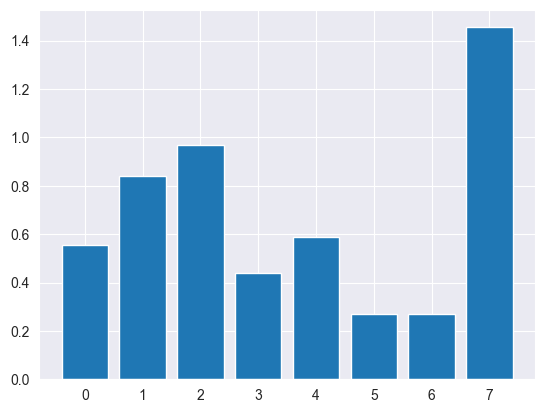

In [16]:
plt.bar(x, degrees)

# lets look at other-ways to find shift in the distribution

In [17]:

def plot_nth_element_pdf(arrays1, arrays2, n, feature_name):

    # Extract the nth element from each array in the first list
    nth_elements1 = [array[n] for array in arrays1 if len(array) > n]
    
    # Extract the nth element from each array in the second list
    nth_elements2 = [array[n] for array in arrays2 if len(array) > n]
    
    # Check if both nth_elements lists are not empty
    if not nth_elements1:
        print(f"No elements found at index {n} in the first list of arrays.")
        return
    if not nth_elements2:
        print(f"No elements found at index {n} in the second list of arrays.")
        return
    
    # Convert lists to numpy arrays for convenience
    nth_elements1 = np.array(nth_elements1)
    nth_elements2 = np.array(nth_elements2)
    
    # Plot the PDF using seaborn for both sets of elements
    sns.kdeplot(nth_elements1, fill=True, label='Input distribution')
    sns.kdeplot(nth_elements2, fill=True, label='Evolved distribution')
    
    # Adding labels, title, and legend
    plt.xlabel(f'feature space: {feature_name}')
    plt.ylabel('Density')
    plt.title(f'PDF distribution for the {feature_name}')
    plt.legend()
    
    # Show the plot
    plt.show()
    
def plot_distribution_shift_for_each_element(input_list, evolved_x, features):
    for i in range(0, len(features)):
        plot_nth_element_pdf(input_list, evolved_x, i, features[i])

def analyse_distribution_shift(phenotype_per_sample_collection, input_list, features):
    evolved_x = []
    for i, sample in enumerate(phenotype_per_sample_collection):
        changed_input = []
        for phenotype in sample:
            x = copy.deepcopy(input_list[i])
            x_out = apply_phenotype(x, phenotype)
            changed_input.append(x_out)
        # print(np.array(changed_input).shape)
        evolved_x.append(np.mean(np.array(changed_input), axis=0))
    return evolved_x, input_list
    
    
def analyse_global_phenotype(input_folder, features, features_index=8):
    phenotype_list = []
    phenotype_per_sample_collection = []
    input_list = []
    for i in os.listdir(input_folder):
        if i=='.DS_Store':
            continue
        filename = input_folder + '/' + i + '/' "final_gen.csv"
        input_array_location = input_folder + '/' + i + '/' + 'input_data.npy'
        # print(filename)
        input = load_data(input_array_location)
        # print(input)
        # print(filename)
        data = pd.read_csv(filename)
        data = data.sort_values(by=['o_1'])
        data = data[data['o_1'] < 0.45]
        data['combined_phenotype'] = data.apply(lambda row: combine_operations(row['Phenotype'], input), axis=1)
        phenotype_list.extend(list(data['Phenotype']))
        phenotype_per_sample_collection.append(list(data['combined_phenotype']))
        input_list.append(input)
    
    #  create co-occurence matrix
    cooccurrence_matrix, correlation_matrix = count_index_cooccurrences(phenotype_list, features_index)
    cooccurrence_matrix = np.round(cooccurrence_matrix,decimals = 3) 
    
    G = create_graph_from_matrix(cooccurrence_matrix)
    draw_graph_plotly(G, features)
    evolved_x, input_list = analyse_distribution_shift(phenotype_per_sample_collection, input_list, features)
    
    plot_distribution_shift_for_each_element(input_list, evolved_x, features)
    # print(average_movement)
    return input_list, evolved_x, cooccurrence_matrix, G, phenotype_per_sample_collection, correlation_matrix



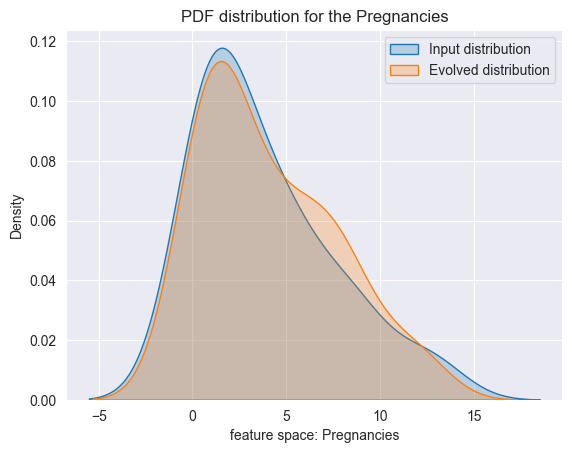

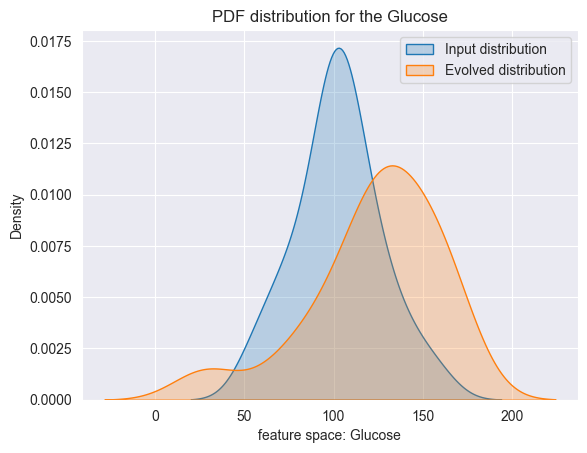

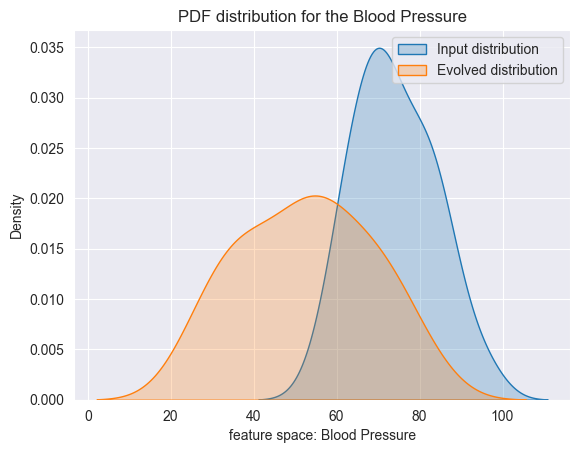

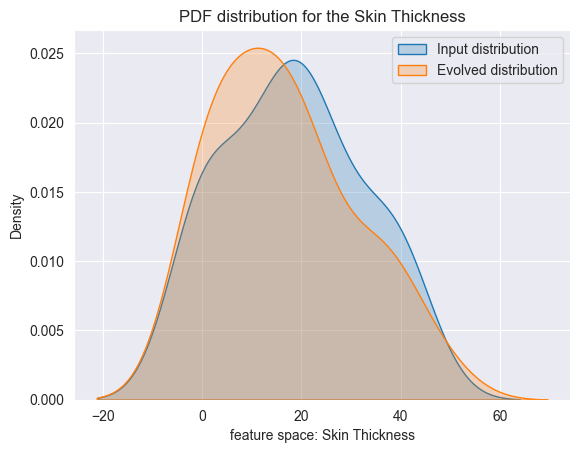

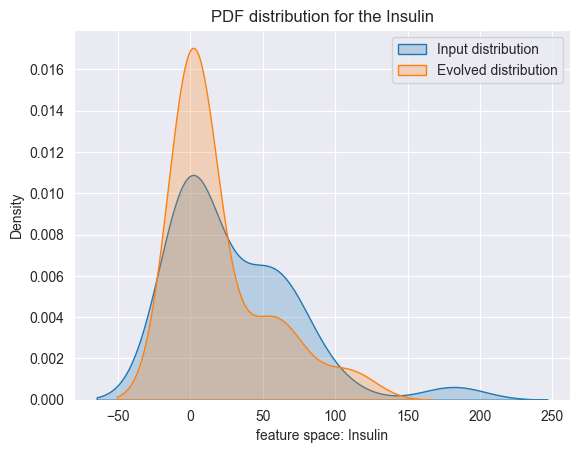

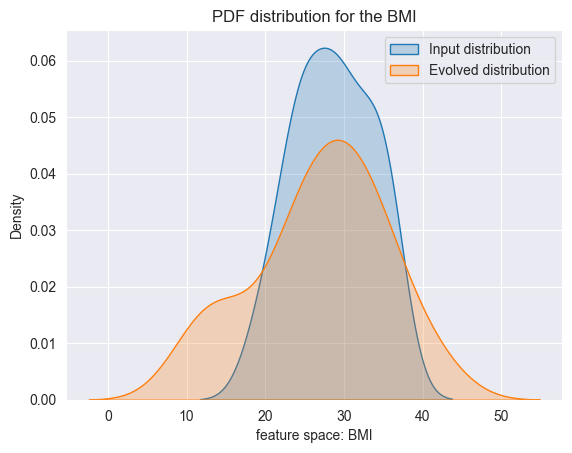

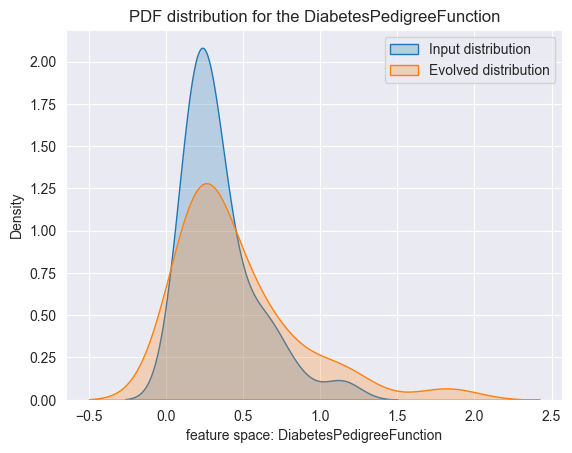

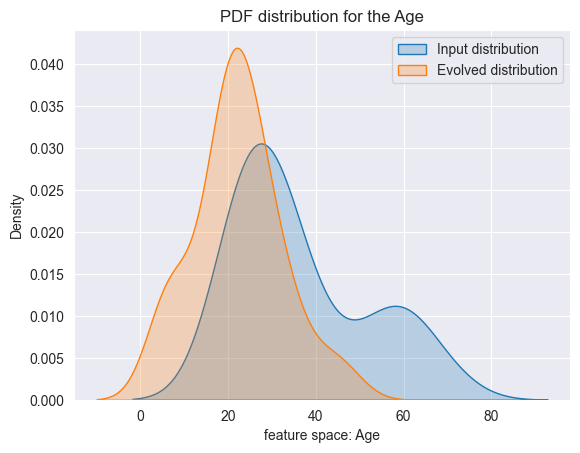

In [18]:
input_list, evolved_x, cooccurrence_matrix, Graph, phenotype_per_sample_collection, correlation_matrix = analyse_global_phenotype(input_folder, features)